<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/Fused_Representation_Hateful_Meme_ResNet_101_Experiment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fused Hateful Memes
# !gdown https://drive.google.com/uc?id=1wgl3QGXZ4m2aLg3T-1TDXQqSP31RuXgL

In [ ]:
# !unzip /content/hateful_ViT1.zip

In [ ]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# Extract Images

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !gdown https://drive.google.com/uc?id=1M2YUllJjmrYW4c_FXcQvHu15mNdDa6Ah

In [ ]:
# import zipfile

# zip_path = '/content/mulitmodal_balanced.zip'
# extract_path = '/content/Data/'

In [ ]:
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [ ]:
# path = "/content/multi_model-images-val.rar"

In [ ]:
# patoolib.extract_archive(path, outdir="/content/Data/" )

# Loading Training Dataset and Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    # def __getitem__(self, index):
    #     while True:
    #         try:
    #             image, label = self.dataset[index]
    #             return image, label
    #         except (UnidentifiedImageError, FileNotFoundError) as e:
    #             print(f"Error loading image at index {index}: {e}")
    #             index += 1

    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [ ]:
data_dir = "/content/hateful_ViT1/train"
dataset = TrainingDataset(data_dir)

In [ ]:
print("Number of samples:", len(dataset))
print("Number of classes:", len(dataset.classes))

Number of samples: 26500
Number of classes: 2


In [ ]:
batch_size = 16
num_workers = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# EDA

In [ ]:
class_length = dataset.class_lengths
class_labels = list(class_length.keys())

In [ ]:
from torchvision.transforms import ToPILImage

def plot_sample_images(dataset):


    # Create a grid layout based on the number of classes
    num_classes = len(class_length)
    grid_cols = 4  # Number of columns in the grid
    grid_rows = (num_classes + grid_cols - 1) // grid_cols  # Number of rows in the grid
    plt.figure(figsize=(10, 5 * grid_rows))

    # Create a transform to convert the tensor to PIL Image
    to_pil = ToPILImage()

    # Iterate over each class
    for i, class_label in enumerate(class_labels):
        # Get a random image index from the class
        image_index = np.random.choice(class_length[class_label])

        # Get the image and label from the dataset
        image, label = dataset[image_index]

        # Convert the image tensor to PIL Image
        image = to_pil(image)

        # Plot the image
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(image, interpolation='none')  # Use 'RGB' interpolation
        plt.title(class_label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
plot_sample_images(dataset)

In [ ]:
class_lengths_dict = dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 2
Total sum: 26500
dict_values([16860, 9640])


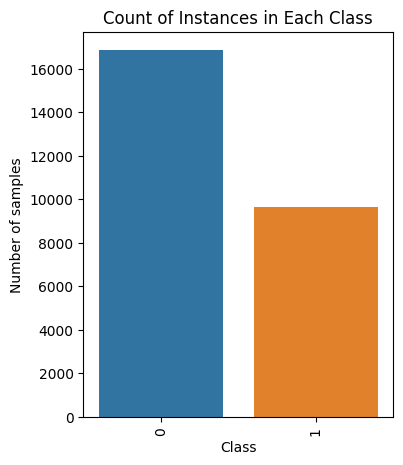

In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Create a count plot
plt.figure(figsize=(4, 5))
sns.barplot(x=class_labels, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class')
plt.show()

# Loading ResNet-101

In [ ]:
num_classes = dataset.get_num_classes()
print("Number of classes:", num_classes)

Number of classes: 2


In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)  # num_classes is the number of classes in your dataset
resnet.to(device)
print(resnet)

# Fine Tuning

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 25

In [ ]:
training_loss = []
resnet.train()

for epoch in range(num_epochs):
    # Set the model to training mode
    running_loss = 0.0

    # Iterate over the data loader
    for images, labels in data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    training_loss.append(epoch_loss)
    # Print the epoch loss
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

Epoch 1/25 Loss: 0.6348
Epoch 2/25 Loss: 0.5156
Epoch 3/25 Loss: 0.3987
Epoch 4/25 Loss: 0.3151
Epoch 5/25 Loss: 0.2556
Epoch 6/25 Loss: 0.2022
Epoch 7/25 Loss: 0.1691
Epoch 8/25 Loss: 0.1403
Epoch 9/25 Loss: 0.1187
Epoch 10/25 Loss: 0.1103
Epoch 11/25 Loss: 0.0836
Epoch 12/25 Loss: 0.0860
Epoch 13/25 Loss: 0.0772
Epoch 14/25 Loss: 0.0627
Epoch 15/25 Loss: 0.0697
Epoch 16/25 Loss: 0.0517
Epoch 17/25 Loss: 0.0475
Epoch 18/25 Loss: 0.0412
Epoch 19/25 Loss: 0.0424
Epoch 20/25 Loss: 0.0370
Epoch 21/25 Loss: 0.0312
Epoch 22/25 Loss: 0.0224
Epoch 23/25 Loss: 0.0337
Epoch 24/25 Loss: 0.0266
Epoch 25/25 Loss: 0.0232


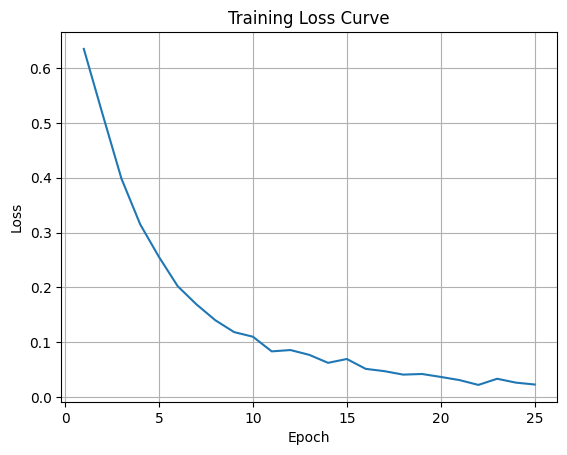

In [ ]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Save Model

In [ ]:
save_dir = "/content/Model/Fused_ResNetmodel_Hatefull_Experiment#3"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

save_path = os.path.join(save_dir, 'model.pth')  # Specify the complete path to the model file
torch.save(resnet.state_dict(), save_path)